In [1]:
# Import packages used in all code
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.utils import resample
from random import seed
from random import randint
from sklearn.metrics import roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from numpy import argmax
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import os
import seaborn as sns
from random import sample
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from IPython.display import Image
from pydotplus import graph_from_dot_data
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.neural_network import MLPClassifier

##############################################################################################
#resample_features
#resamples data with Pb violations to match complient data 
#Params: features: features to resample, labels: corresponding labels, multiplier: defines
#        length of resampled set
##############################################################################################


def resample_features(features, labels, multiplier):
    zeros = np.where(labels == 0)
    ones = np.where(labels == 1)
    features_zero = features[zeros]
    features_one = features[ones]
    features_one = resample(features_one, replace=True,n_samples=len(features_zero)*multiplier, 
                            random_state=42)
    features_zero = np.insert(features_zero, 0, 0, axis=1)
    features_one = np.insert(features_one, 0, 1, axis=1)
    features_final = np.append(features_zero, features_one, axis=0)
    return features_final

##############################################################################################
#Random number generator
#returns a randomly generated array with the same length as the train labels by using the test 
#labels to generate a prob distribution
#Params: y_train: train labels, y_test: test labels
##############################################################################################


def random_number_gen(y_train, y_test):
    seed(42)
    prob_Pb = round(sum(y_train)/len(y_train),2)*100
    random_gen=[]
    for i in range(y_test.shape[0]):
        random_num = randint(0, 100)
        if random_num<=prob_Pb:
            result = 1
        else:
            result = 0
        random_gen.append(result)
    return random_gen

##############################################################################################
#Drop column score
#calculates OOB score or ROC AUC score as features are dropped out of the model
#Params: model: any classifier, X_train: train features, y_train: train labels, 
#        X_test: test features, y_test: test labels, mode: optimize based on OOB or ROC AUC
##############################################################################################
def drop_col_feat_imp(model, X_train, y_train, X_test, y_test, mode):
    model_clone = model
    importances = []
    if mode == 'OOB':
        model_clone.fit(X_train, y_train)
        benchmark_score = model_clone.oob_score_
        for col in range(X_train.shape[1]):
            X_train_drop = np.delete(X_train, col, 1)
            X_test_drop = np.delete(X_test, col, 1)
            model_clone.fit(X_train_drop, y_train)
            drop_score = model_clone.oob_score_
            importances.append(benchmark_score - drop_score)

        importances_df = importances
    
    elif mode == 'AUC':
        model_clone.fit(X_train, y_train)
        predicted_proba = model_clone.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, predicted_proba[:,1])
        roc_auc = auc(fpr, tpr)
        benchmark_score = roc_auc
        for col in range(X_train.shape[1]):
            X_train_drop = np.delete(X_train, col, 1)
            X_test_drop = np.delete(X_test, col, 1)
            model_clone.fit(X_train_drop, y_train)
            predicted_proba = model_clone.predict_proba(X_test_drop)
            fpr, tpr, thresholds = roc_curve(y_test, predicted_proba[:,1])
            roc_auc = auc(fpr, tpr)
            drop_score = roc_auc
            importances.append(benchmark_score - drop_score)

        importances_df = importances
    
    return importances_df, benchmark_score

##############################################################################################
#Preprocess data
#preprocessess data for use in random forest by transformin categorical data and getting rid of text
#option to normalize and to chose Pb violation threshold 
#normalize if normalize = True. Threshold may be 5, 10 or 15
#Params: df: complete dataframe with all data, Pb_threshold: threshold to binarize label,
#        normalize: normalization option
##############################################################################################
def preprocess_data(df, Pb_threshold, normalize):
    #Obtain features and labels from imported file
    if Pb_threshold == 5:
        labels = df['ProbCategory_5_ppb']
    elif Pb_threshold == 10:
        labels = df['ProbCategory_10_ppb']
    elif Pb_threshold == 15:
        labels = df['ProbCategory_15_ppb']
    features = df
    
    #drop unnecessary columns
    features.drop('ProbCategory_15_ppb', inplace = True, axis = 1)
    features.drop('ProbCategory_10_ppb', inplace = True, axis = 1)
    features.drop('ProbCategory_5_ppb', inplace = True, axis = 1)
    features.drop('RESULT', inplace = True, axis = 1)
    features.drop('DISINFECTANT', inplace = True, axis = 1)
    features.drop('County', inplace = True, axis = 1)
    features.drop('System_average', inplace = True, axis = 1)
    features.drop(features.iloc[:, 0:6], inplace = True, axis = 1) 

    # use Imputer to fill in missing feature data with the mean of the column
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    missing_values= imputer.fit(features)
    features = imputer.transform(features)

    #normalize data (optional)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(features)
        features = x_scaled
    print(features.shape)
    return features, labels



In [10]:
##############################################################################################
#Random forest model - predicts whether Pb leaching is likely to occur in a school based on 
#water quality and socio-economic data
##############################################################################################

#read excel file with features (inputs) and labels (outputs)
Pb_data = pd.read_excel('CA dataset 2.xlsx')

#preprocess data
features, labels = preprocess_data(Pb_data, 15, True)

#split features and lables into train and test set
train_features, test_features, train_labels, test_labels= train_test_split(features, 
    labels, test_size = 0.3, random_state = 42)

#resample features and labels
train_features = resample_features(train_features, train_labels,2)
train_labels = train_features[:,0]
train_features = np.delete(train_features, 0, axis=1)
test_features = resample_features(test_features, test_labels,2)
test_labels = test_features[:,0]
test_features = np.delete(test_features, 0, axis=1)

#display size of train and test set
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

# Create random forest model
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, criterion='entropy', max_depth= 20, oob_score=True, class_weight={0:1,1:100})

# Fit model
rf.fit(train_features, train_labels)

#Define decision threshold for random forest
threshold = 0.5

# Predict using selected threshold
predicted_proba = rf.predict_proba(test_features)
rf_prediction = (predicted_proba [:,1] >= threshold).astype('int')



(4509, 92)
Training Features Shape: (8937, 92)
Training Labels Shape: (8937,)
Testing Features Shape: (3852, 92)
Testing Labels Shape: (3852,)


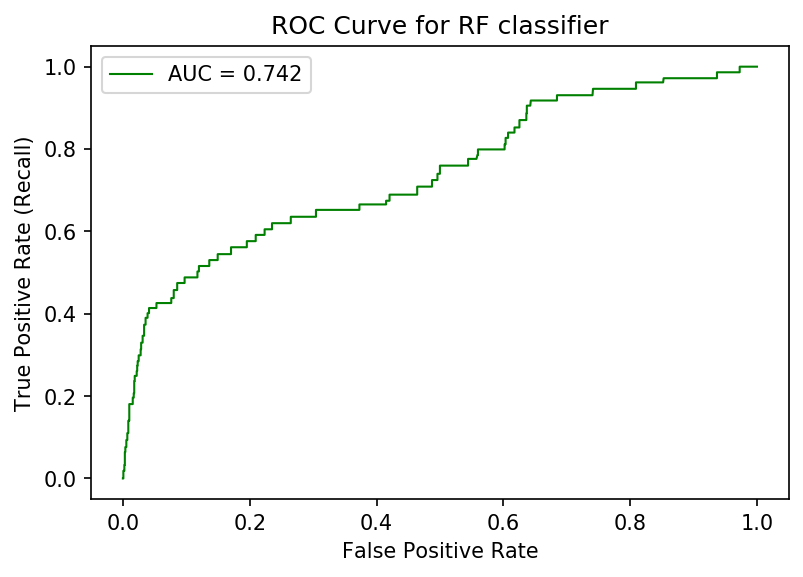

Best Threshold=0.112942, F-Score=0.820


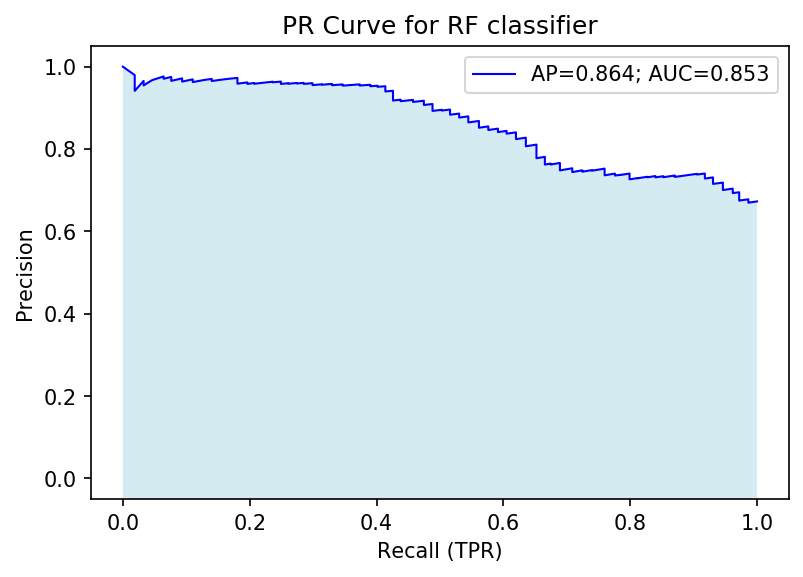

In [11]:
#plot ROC curve
# get false and true positive rates
fpr, tpr, thresholds = roc_curve(test_labels, predicted_proba[:,1])
# get area under the curve
roc_auc = auc(fpr, tpr)
# PLOT ROC curve
plt.figure(dpi=150)
plt.plot(fpr, tpr, lw=1, color='green', label=f'AUC = {roc_auc:.3f}')
plt.title('ROC Curve for RF classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

#plot precision-recall curve

# get precision and recall values
precision, recall, thresholds = precision_recall_curve(test_labels, predicted_proba[:,1])
# average precision score
avg_precision = average_precision_score(test_labels, predicted_proba[:,1])
# precision auc
pr_auc = auc(recall, precision)
#chose best threshold based on f score
zeros = np.where(precision == 0)
precision = np.delete(precision, zeros)
recall = np.delete(recall, zeros)
thresholds= np.delete(thresholds, zeros)
fscore = (2 * precision * recall) / (precision + recall)
fscore = fscore[np.logical_not(np.isnan(fscore))]
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# plot
plt.figure(dpi=150)
plt.plot(recall, precision, lw=1, color='blue', label=f'AP={avg_precision:.3f}; AUC={pr_auc:.3f}')
#plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.fill_between(recall, precision, -1, facecolor='lightblue', alpha=0.5)
plt.title('PR Curve for RF classifier')
plt.xlabel('Recall (TPR)')
plt.ylabel('Precision')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()




In [12]:
##############################################################################################
#Data analysis
##############################################################################################
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
rfc_cv_score = cross_val_score(rf, features, labels, cv=cv, scoring='roc_auc')

#OOB score
rf_clone = clone(rf)
oob_features, oob_labels = shuffle(features,labels)
rf_clone.fit(oob_features, oob_labels)
OOB_score = rf_clone.oob_score_

#calculate random predictions using a random number generator to compare to RF data
random_prediction = random_number_gen(train_labels, test_labels)

print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')

print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())
print('\n')

print("=== Out of Bag Error ===")
print("OOB Score - Random Forest: ", OOB_score)
print('\n')

print("=== Data ===")
print('1:', sum(test_labels),'0:',len(test_labels) - sum(test_labels))
print('\n')

print("=== Confusion Matrix - Random Forest ===")
print(confusion_matrix(test_labels, rf_prediction, labels=[1,0]))
print('\n')

print("=== Confusion Matrix - Random Number Generator ===")
print(confusion_matrix(test_labels, random_prediction, labels=[1,0]))
print('\n')

print("=== Classification Report - Random Forest ===")
print(classification_report(test_labels, rf_prediction, labels=[1,0]))
print('\n')

print("=== Classification Report - Random Number Generator ===")
print(classification_report(test_labels, random_prediction, labels=[1,0]))
print('\n')




=== All AUC Scores ===
[0.77991106 0.6869892  0.70882353 0.70561747 0.70114494 0.74457357
 0.74697921 0.70908973 0.72783069 0.72197499]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7232934391191328


=== Out of Bag Error ===
OOB Score - Random Forest:  0.9285872699046351


=== Data ===
1: 2568.0 0: 1284.0


=== Confusion Matrix - Random Forest ===
[[1399 1169]
 [ 213 1071]]


=== Confusion Matrix - Random Number Generator ===
[[1698  870]
 [ 850  434]]


=== Classification Report - Random Forest ===
              precision    recall  f1-score   support

           1       0.87      0.54      0.67      2568
           0       0.48      0.83      0.61      1284

    accuracy                           0.64      3852
   macro avg       0.67      0.69      0.64      3852
weighted avg       0.74      0.64      0.65      3852



=== Classification Report - Random Number Generator ===
              precision    recall  f1-score   support

           1       0.67      0.66      0

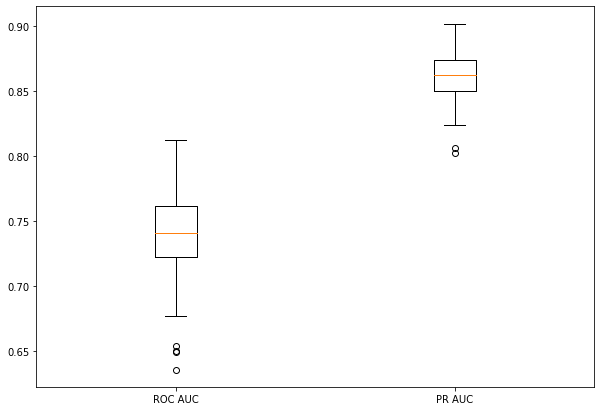

In [13]:
#Figure 3
##############################################################################################
#ROC-AUC and PR-AUC for various splits
#obtains the ROC-AUC and PR-AUC values and charts for 100 runs of RF
##############################################################################################

ROCs = []
PRs = []
for state in range(500,5000,50):
    
    train_features, test_features, train_labels, test_labels= train_test_split(features, 
        labels, test_size = 0.2, random_state = state)

    train_features = resample_features(train_features, train_labels,2)
    train_labels = train_features[:,0]
    train_features = np.delete(train_features, 0, axis=1)

    test_features = resample_features(test_features, test_labels,2)
    test_labels = test_features[:,0]
    test_features = np.delete(test_features, 0, axis=1)
    
    rf_optimum = RandomForestClassifier()
    
    rf_optimum.fit(train_features, train_labels)
    probas = rf_optimum.predict_proba(test_features)
    
    #ROC curve
    # get false and true positive rates
    fpr, tpr, thresholds = roc_curve(test_labels, probas[:,1])
    # get area under the curve
    roc_auc = auc(fpr, tpr)
    ROCs.append(roc_auc)
    
    #PR curve
    precision, recall, thresholds = precision_recall_curve(test_labels, probas[:,1])
    # average precision score
    avg_precision = average_precision_score(test_labels, probas[:,1])
    # precision auc
    pr_auc = auc(recall, precision)
    PRs.append(pr_auc)
    
fig = plt.figure(figsize =(10, 7)) 
  
# Creating plot 
ROC_PR_data = [ROCs, PRs]
plt.boxplot(ROC_PR_data, labels = ['ROC AUC', 'PR AUC']) 
  
# show plot 
plt.show() 

Feature ranking:


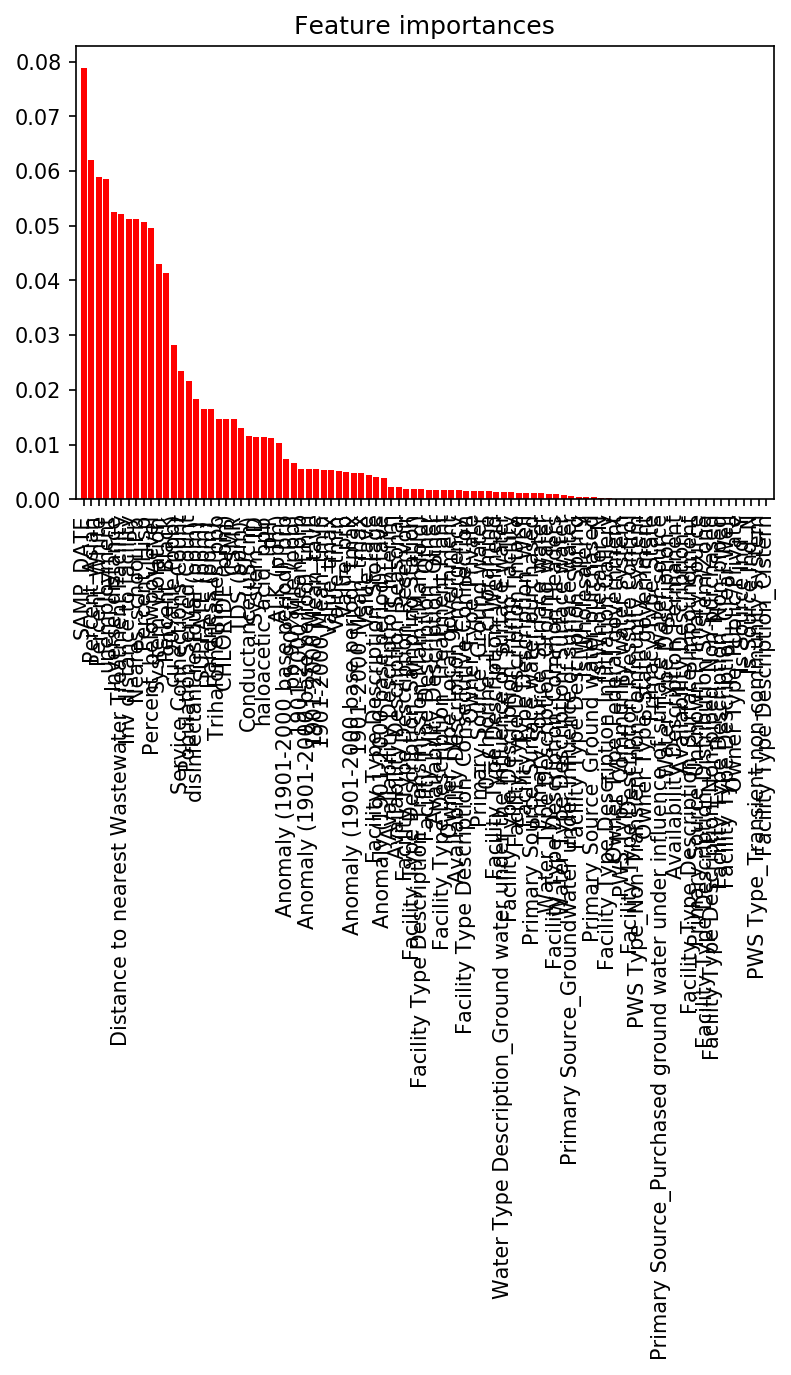

In [14]:
##############################################################################################
#Feature importance analysis
#
##############################################################################################
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_head = Pb_data.columns
feature_head= feature_head[indices]
# Print the feature ranking
print("Feature ranking:")

# Plot the impurity-based feature importances of the forest
plt.figure(dpi=150)
plt.title("Feature importances")
plt.bar(range(train_features.shape[1]), importances[indices],
        color="r")
plt.xticks(range(train_features.shape[1]), feature_head, rotation='vertical')
plt.xlim([-1, train_features.shape[1]])
plt.show()


In [16]:
names = ['all','water_social', 'social_spatial', 'spatial_water']
AUC_variables = []
for sheetname in names:

#read excel file with features (inputs) and labels (outputs)
    Pb_data = pd.read_excel('CA dataset.xlsx', sheet_name = sheetname )

    #Obtain features and labels from imported file
    labels_s = Pb_data['ProbCategory_5_ppb']
    features_s = Pb_data
    features_s.drop('ProbCategory_15_ppb', inplace = True, axis = 1)
    features_s.drop('ProbCategory_10_ppb', inplace = True, axis = 1)
    features_s.drop('ProbCategory_5_ppb', inplace = True, axis = 1)
    features_s.drop('RESULT', inplace = True, axis = 1)
    features_s.drop('DISINFECTANT', inplace = True, axis = 1)
    features_s.drop(Pb_data.iloc[:, 0:6], inplace = True, axis = 1) 

    # use Imputer to fill in missing feature data with the mean of the column
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    missing_values= imputer.fit(features_s)
    features_s = imputer.transform(features_s)
    
    random_states = range(20,200,5)
    AUCs = []
    for r in random_states:
        # Using Skicit-learn to split data into training and testing sets
        train_features_s, test_features_s, train_labels_s, test_labels_s= train_test_split(features_s, 
            labels_s, test_size = 0.3, random_state = r)

        #resample
        train_features_s = resample_features(train_features_s, train_labels_s,2)
        train_labels_s = train_features_s[:,0]
        train_features_s = np.delete(train_features_s, 0, axis=1)

        test_features_s = resample_features(test_features_s, test_labels_s,2)
        test_labels_s = test_features_s[:,0]
        test_features_s = np.delete(test_features_s, 0, axis=1)

        rf = RandomForestClassifier()
        rf.fit(train_features_s, train_labels_s)
        predicted_proba_s = rf.predict_proba(test_features_s)
        rf_roc_auc_1 = metrics.roc_auc_score(test_labels_s, predicted_proba_s[:,1])
        AUCs.append(rf_roc_auc_1)

    print(sheetname, ':', np.average(AUCs), np.std(AUCs))
    AUC_variables.append(AUCs)




all : 0.7450689113931515 0.01943918700094311
water_social : 0.6793028091952541 0.01787476883811904
social_spatial : 0.7085795440380162 0.017770782108995783
spatial_water : 0.756139967345309 0.017267435099882156
